In [29]:
import cv2
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import socket
import sys

from keras.models import load_model, Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [30]:
path = "IITBBS_Dataset"
images = []
classNo = []
testRatio = 0.2
batchSizeVal = 48
stepsPerEpochVal = 200
epochsVal = 50
valRatio = 0.2
imageDimensions = (32, 32, 3)

In [31]:
myList = os.listdir(path)
# print(myList)
noOfClasses = len(myList)
for x in range(0, noOfClasses):
    myPicList = os.listdir(path+"/"+myList[x])
    for y in myPicList:
        # split the file path into base name and extension
        base_name, extension = os.path.splitext(y)
        if extension == '.jpg' and extension != '.db':
            curImg = cv2.imread(path+"/"+myList[x]+"/"+y, cv2.IMREAD_COLOR)
        # check if the extension matches '.tif'
        elif extension == '.tif' and extension != '.db':
            curImg = cv2.imread(path+"/"+myList[x]+"/"+y, cv2.IMREAD_UNCHANGED)
            # Convert the image to JPEG format
            cv2.imwrite(path+"/"+myList[x]+"/"+base_name+'.jpg',
                        curImg, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
            curImg = cv2.imread(
                path+"/"+myList[x]+"/"+base_name+'.jpg', cv2.IMREAD_COLOR)
        curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))
        images.append(curImg)
        classNo.append(x)
    # print(x)
print(len(images))

17838


In [33]:
images = np.array(images)
classNo= np.array(classNo)

x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio, random_state=69)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=valRatio, random_state=69)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

numOfSamples = []
for x in range(0,noOfClasses):
   # #It is giving us for each class how many images do we have
    numOfSamples.append(len(np.where(y_train==x)[0]))
print(numOfSamples)  


(11416, 32, 32, 3)
(3568, 32, 32, 3)
(2854, 32, 32, 3)
[159, 212, 86, 79, 67, 88, 73, 51, 77, 80, 71, 71, 69, 89, 85, 80, 73, 59, 94, 78, 94, 83, 86, 98, 81, 81, 92, 321, 92, 85, 91, 83, 86, 76, 80, 76, 96, 87, 341, 82, 88, 88, 77, 82, 81, 80, 77, 82, 85, 324, 70, 87, 79, 86, 79, 76, 88, 86, 79, 73, 335, 91, 76, 78, 74, 74, 92, 82, 72, 82, 92, 301, 77, 43, 67, 78, 76, 77, 77, 84, 78, 85, 352, 78, 75, 88, 68, 86, 65, 72, 79, 80, 73, 327, 77, 91, 64, 86, 74, 82, 76, 78, 83, 90, 335, 84, 88, 87, 95, 82, 71, 87, 83, 83, 67]


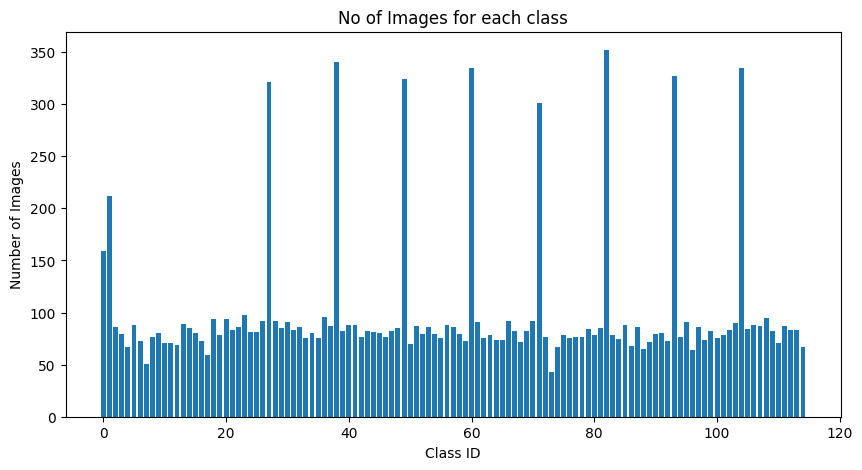

In [34]:
plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses),numOfSamples)
plt.title("No of Images for each class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [35]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [36]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5, 5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2, 2)
    noOfNode = 500

    model = Sequential()
    model.add((Conv2D(noOfFilters, sizeOfFilter1, input_shape=(
        imageDimensions[0], imageDimensions[1], 1), activation='relu')))
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))

    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
x_train = np.array(list(map(preProcessing, x_train)))
x_test = np.array(list(map(preProcessing, x_test)))
x_validation = np.array(list(map(preProcessing, x_validation)))

x_train = x_train.reshape(
    x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_validation = x_validation.reshape(
    x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1)

y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

In [38]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(x_train)

In [39]:
model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [40]:
history = model.fit(dataGen.flow(x_train, y_train, batch_size=batchSizeVal),
                    steps_per_epoch=stepsPerEpochVal,
                    epochs=epochsVal,
                    validation_data=(x_validation, y_validation),
                    shuffle=1)

Epoch 1/50
200/200 [==============================] - 26s 127ms/step - loss: 4.4005 - accuracy: 0.0536 - val_loss: 4.0447 - val_accuracy: 0.0932
Epoch 2/50
200/200 [==============================] - 26s 128ms/step - loss: 3.9545 - accuracy: 0.1179 - val_loss: 3.6047 - val_accuracy: 0.1685
Epoch 3/50
200/200 [==============================] - 26s 129ms/step - loss: 3.7050 - accuracy: 0.1569 - val_loss: 3.3717 - val_accuracy: 0.2134
Epoch 4/50
200/200 [==============================] - 25s 127ms/step - loss: 3.4898 - accuracy: 0.1859 - val_loss: 3.0709 - val_accuracy: 0.2863
Epoch 5/50
200/200 [==============================] - 25s 126ms/step - loss: 3.3590 - accuracy: 0.2056 - val_loss: 2.8994 - val_accuracy: 0.2992
Epoch 6/50
200/200 [==============================] - 26s 128ms/step - loss: 3.2335 - accuracy: 0.2247 - val_loss: 2.8787 - val_accuracy: 0.2999
Epoch 7/50
200/200 [==============================] - 26s 128ms/step - loss: 3.1122 - accuracy: 0.2440 - val_loss: 2.6649 - val_ac

In [41]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss Score = ',score[0])
print('Test Accuracy = ',score[1])

Test Loss Score =  1.3332915306091309
Test Accuracy =  0.6101457476615906


In [42]:
# Saving the model
pickle_out = open("model_trained_iitbbs.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

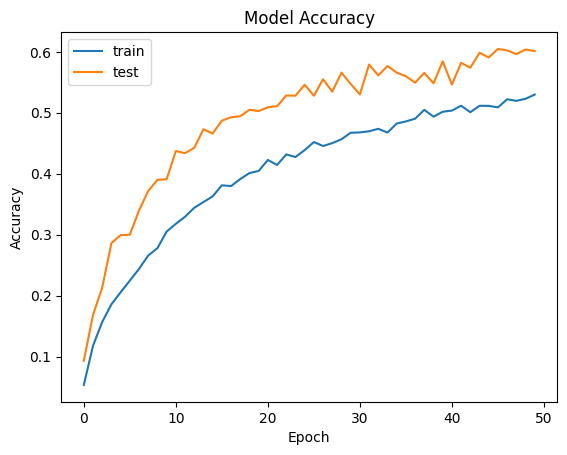

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()